# Keras mnist MLP-2L
**此项目测试多层感知机-单隐藏层**

In [1]:
%matplotlib inline
import os
import PIL
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from IPython import display
from functools import partial
from sklearn.preprocessing import normalize

from keras import backend
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Input, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, BatchNormalization

import warnings 
warnings.filterwarnings('ignore')
np.random.seed(42)

Using TensorFlow backend.


In [8]:
file_path = r"I:\Dataset\mnist\all_mnist_data.csv"
mnist_data = pd.read_csv(file_path)

idx = np.random.permutation(len(mnist_data))
train_data = mnist_data.iloc[idx[: 60000]]
test_data = mnist_data.iloc[idx[60000: ]]

X_train = np.array(train_data.drop('0', axis=1)).reshape(-1, 28, 28, 1).astype("float32")
X_test  = np.array(test_data.drop('0', axis=1)).reshape(-1, 28, 28, 1).astype("float32")

y_train = np.array(train_data['0'])
y_test  = np.array(test_data['0'])
y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test)

x_train = X_train[10000:]
t_train = y_train[10000:]
x_val   = X_train[:10000].reshape(-1, 784)
t_val   = y_train[:10000]

print("\nimgs   of trainset : ", x_train.shape)
print("labels of trainset : ", t_train.shape)
print("imgs   of   valset : ", x_val.shape)
print("labels of   valset : ", t_val.shape)
print("imgs   of  testset : ", X_test.shape)
print("labels of  testset : ", y_test.shape)


imgs   of trainset :  (50000, 28, 28, 1)
labels of trainset :  (50000, 10)
imgs   of   valset :  (10000, 784)
labels of   valset :  (10000, 10)
imgs   of  testset :  (10000, 28, 28, 1)
labels of  testset :  (10000, 10)


In [3]:
def myNN():
    model = Sequential()

    model.add(Dense(units=512, input_dim=784, kernel_initializer="normal",
                    activation="relu"))
    model.add(Dense(units=10, kernel_initializer="normal", activation="softmax"))
    return model
model = myNN()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
backend.set_session(sess)

In [9]:
"""训练模型并保存模型及训练历史
保存模型单独创建一个子文件夹modeldir, 保存训练历史则为单个文件hisfile"""

models_name = "Keras_mnist_MLP_2L" # 模型名称的公共前缀
factor_list = [""] # 此次调参的变量列表

model_list = []      # 模型名称列表
for i in range(len(factor_list)):
    modelname = models_name + factor_list[i] + ".h5"
    model_list.append(modelname)

# 创建模型保存子目录modeldir
if not os.path.isdir("saved_models"): 
    os.mkdir("saved_models")
modeldir = r"saved_models"

# 创建训练历史保存目录
if not os.path.isdir("train_history"): 
    os.mkdir("train_history")
# 设置训练历史文件路径
hisfile = r"train_history\Keras_mnist_MLP_2L.train_history" 
# 每个模型及其对应的训练历史作为键值对{modelname: train_history}
# train_history为字典，含四个key，代表train和val的loss和acc
model_train_history = dict() 


# 开始训练
epochs=100
batch_size = 32
steps_per_epoch=1250
for i in range(len(model_list)):
    model = myNN()
    modelname = model_list[i]
    modelpath = os.path.join(modeldir, modelname)    
    
    train_his = np.array([]).reshape(-1, 2)
    val_his = np.array([]).reshape(-1, 2)
    datagen = ImageDataGenerator()
    datagen.fit(x_train)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(),
                  metrics=["accuracy"])
    print("\ntraining model : ", modelname)
    
    ck_epoch, max_val_acc = 0, 0.0
    for epoch in range(epochs+1):
        i = 0
        tr_his = []
        for X, y in datagen.flow(x_train, t_train, batch_size=batch_size):
            X = X.reshape(-1, 784)
            his = model.train_on_batch(X, y)
            tr_his.append(his)
            i += 1
            if i >= steps_per_epoch: break
        tr = np.mean(tr_his, axis=0)
        val = model.evaluate(x_val, t_val, verbose=0)
        train_his = np.vstack((train_his, tr))
        val_his = np.vstack((val_his, val))
        if epoch<10 or epoch%5==0:
            print("%4d epoch: train acc: %8f loss: %8f      val acc: %8f loss: %8f"%(epoch, tr[1], tr[0], val[1], val[0]))
        # 设置保存模型
        if val[1] > max_val_acc: 
            model.save(modelpath)
            print("val acc improved from %6f to %6f"%(max_val_acc, val[1]))
            max_val_acc = val[1]
            ck_epoch = epoch
        # 超过20个周期性能没有提升
        if epoch-ck_epoch > 20:
            print("Early stop !")
            break
    model_train_history[modelname] = {"acc": train_his[:, 1], "val_acc": val_his[:, 1],
                                      "loss": train_his[:, 0], "val_loss": val_his[:, 0]}

"""保存训练历史"""
fo = open(hisfile, 'wb')
pickle.dump(model_train_history, fo)
fo.close() 


training model :  Keras_mnist_MLP_2L.h5
   0 epoch: train acc: 0.927850 loss: 0.244417      val acc: 0.961800 loss: 0.127881
val acc improved from 0.000000 to 0.961800
   1 epoch: train acc: 0.970450 loss: 0.098839      val acc: 0.969500 loss: 0.097090
val acc improved from 0.961800 to 0.969500
   2 epoch: train acc: 0.980700 loss: 0.064536      val acc: 0.974400 loss: 0.081762
val acc improved from 0.969500 to 0.974400
   3 epoch: train acc: 0.984900 loss: 0.047615      val acc: 0.975200 loss: 0.079933
val acc improved from 0.974400 to 0.975200
   4 epoch: train acc: 0.988825 loss: 0.034814      val acc: 0.975800 loss: 0.076806
val acc improved from 0.975200 to 0.975800
   5 epoch: train acc: 0.990900 loss: 0.028526      val acc: 0.979200 loss: 0.073518
val acc improved from 0.975800 to 0.979200
   6 epoch: train acc: 0.993300 loss: 0.022067      val acc: 0.976600 loss: 0.091331
   7 epoch: train acc: 0.992975 loss: 0.020637      val acc: 0.980500 loss: 0.076438
val acc improved from

In [10]:
def show_train_history(saved_history, his_img_file):  
    modelnames = sorted(list(saved_history.keys()))
    train = ["acc", "loss"]
    val = ["val_acc", "val_loss"]
    
    """作loss和acc两个图"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    color_add = 0.9/len(saved_history)
    for i in range(2):
        c = 0.05
        for j in range(len(saved_history)):
            modelname = modelnames[j]
            train_history = saved_history[modelname]
            ax[i].plot(train_history[train[i]], 
                       color=(0, 1-c, 0),
                       linestyle="-",
                       label="train_"+modelname[21:-3])
            ax[i].plot(train_history[val[i]], 
                       color=(c, 0, 1-c),
                       linestyle="-",
                       label="val_"+modelname[21:-3])
            c += color_add
        ax[i].set_title('Train History')
        ax[i].set_ylabel(train[i])  
        ax[i].set_xlabel('Epoch')  
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right") 
    ax[0].set_ylim(0.9, 1.0)
    ax[1].set_ylim(0, 0.2)
    plt.suptitle("MLP_2L")
    
    print("saved img: ", his_img_file)
    plt.savefig(his_img_file)
    plt.show()

saved img:  his_img\MLP_2L.png


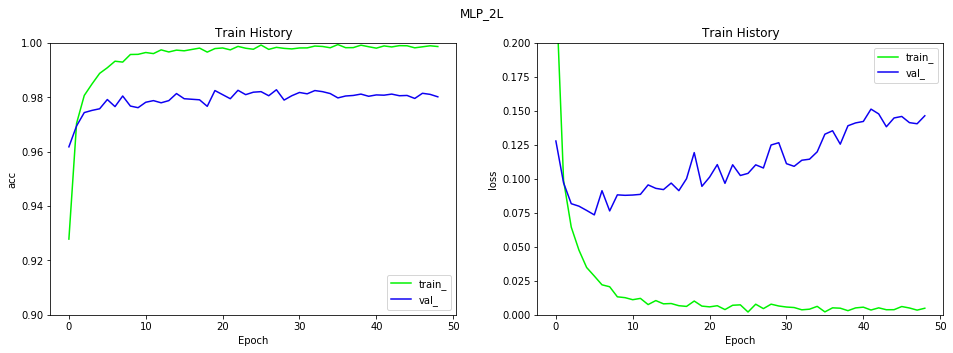

In [11]:
"""载入训练历史并可视化, 并且保存图片"""
if not os.path.isdir("his_img"):
    os.mkdir("his_img")
his_img_file = r"his_img\MLP_2L.png"

fo2 = open(hisfile, "rb")
saved_history1 = pickle.load(fo2)

show_train_history(saved_history1, his_img_file)

In [14]:
smodel = load_model(modelpath)
print("test model: ", os.path.basename(modelpath))
loss, acc = smodel.evaluate(X_test.reshape(-1, 784), y_test)
print("acc: %.4f \t loss: %.4f"%(acc, loss))

test model:  Keras_mnist_MLP_2L.h5
10000/10000 [==============================] - 1s 92us/step
acc: 0.9789 	 loss: 0.1264
